In [1]:
# imports
#from GDapp.models import add_analyzed_image, add_gold_particle_coordinates, add_histogram_image, add_coordinates6nm
import os
from skimage import io  # library for python to help access pictures
import numpy as np  # help do math in python
import matplotlib.pyplot as plt
import random
import imageio
from PIL import Image
import sys

from skimage.util.shape import view_as_windows, view_as_blocks
import imutils

import os
import cv2

import glob
import shutil
import re
import pandas as pd
import pathlib

import time
import errno
import os
import stat
import shutil
from django.conf import settings
# from sklearn.cluster import Kmeans

import imagecodecs

In [2]:
def get_artifact_status(model):
    # gets rid of the constant artifact in the up left corner
    if model == '87kGoldDigger':
        artifact = True
    else:
        artifact = False
    return artifact

In [3]:
def clear_out_old_files(model):
    shutil.rmtree('media/Output', ignore_errors=True)
    os.makedirs('media/Output')

    shutil.rmtree('media/Output_Appended', ignore_errors=True)
    os.makedirs('media/Output_Appended')

    shutil.rmtree('media/Output_Appended/test', ignore_errors=True)
    os.makedirs('media/Output_Appended/test')

    shutil.rmtree(
        'media/PIX2PIX/results/{0}/test_latest/images'.format(model), ignore_errors=True)
    os.makedirs('media/PIX2PIX/results/{0}/test_latest/images'.format(model))

    shutil.rmtree('media/Output_ToStitch', ignore_errors=True)
    os.makedirs('media/Output_ToStitch')

    shutil.rmtree('media/Output_Final', ignore_errors=True)
    os.makedirs('media/Output_Final')

    try:
        os.remove('media/GD_Output.zip')
    except:
        pass

In [4]:
# look in INPUT folder, crop photo and save crop to OUTPUT folder
# Cut up in order, append white images

def load_data_make_jpeg(image, mask):
    file_list = pathlib.Path('media/Input', image)
    print(file_list)
    for entry in [file_list]:

        img_size = (256, 256, 3)
        img_new = io.imread(entry)
        # img_new = (img_new/256).astype('uint8')
        shape = img_new.shape
        height = shape[0] // 256
        height256 = height * 256
        width = shape[1] // 256
        width256 = width * 256

        img_new = img_new[:height256, :width256, :3]
        img_mask = None
        if mask is not None:
            mask_path = pathlib.Path('media/Mask', mask)
            img_mask = io.imread(mask_path)
            img_mask = img_mask[:height256, :width256, :3]
            imageio.imwrite('media/Output_Final/' + 'CroppedMask'+'.png', img_mask)

        img_new_w = view_as_blocks(img_new, img_size)
        img_new_w = np.uint8(img_new_w)
        imageio.imwrite('media/Output_Final/' +
                        'CroppedVersion' + '.png', img_new)
        r = 0
        for i in range(img_new_w.shape[0]):
            for j in range(img_new_w.shape[1]):
                A = np.zeros((img_size[0], img_size[1], 3))
                A[:, :, :] = img_new_w[i, j, :, :]
                # A = np.uint8(A)
                imageio.imwrite('media/Output/' + str(r) + '.png', A)
                r += 1
    return file_list, width, height, img_mask

In [5]:
def combine_white(white, folderA):
    print(os.getcwd())
    os.chdir(folderA)
    for file in os.listdir('.'):
        imA = io.imread(file)
        newimage = np.concatenate((imA, white), axis=1)
        imageio.imwrite('../Output_Appended/test/' + file, newimage)

    os.chdir('../../')
    print(os.getcwd())

In [6]:
# Save to OUTPUT folder
def save_to_output_folder(file_list, model):
    for entry in file_list:
        split_name = entry.split('/')
        print(split_name)
        dirA = 'media/PIX2PIX/results/{0}/test_latest/images/'.format(model)
        pathA = os.path.join(dirA, split_name[-1])
        dirB = 'media/Output_ToStitch/'
        pathB = os.path.join(dirB, split_name[-1])
        shutil.move(pathA, pathB)

In [7]:
# STICH TOGETHER


def stitch_row(n, master, folderstart, artifact, widthdiv256):
    image1 = imageio.imread(folderstart + master[n])
    if (artifact):
        image1[0:35, 220:256, :] = 0
    file1 = np.array(image1)

    image2 = imageio.imread(folderstart + master[n + 1])
    if (artifact):
        image2[0:35, 220:256, :] = 0
    file2 = np.array(image2)

    full_row = np.concatenate((file1, file2), axis=1)
    for i in range(n + 2, n + widthdiv256):
        image3 = imageio.imread(folderstart + master[i])
        if (artifact):
            image3[0:35, 220:256, :] = 0
        file_next = np.array(image3)
        full_row = np.concatenate((full_row, file_next), axis=1)
    return full_row

In [8]:
def stitch_image(folderstart, widthdiv256, heighttimeswidth, artifact):
    files = os.listdir(folderstart)
    file_list = []
    for file in files:
        split_name = re.split('\D', file)
        file_list.append(split_name[0])

    file_list.sort(key=float)
    master = []
    for file in file_list:
        name = file + '_fake_B.png'
        master.append(name)

    picture = stitch_row(0, master, folderstart, artifact, widthdiv256)
    for n in range(widthdiv256, heighttimeswidth, widthdiv256):
        next_row = stitch_row(n, master, folderstart, artifact, widthdiv256)
        picture = np.concatenate((picture, next_row), axis=0)
    return picture, file_list

In [9]:
def count_green_dots():
    # From Diego:
    # 1. Finds green square and then the center of that (x,y)
    # 2. Then I perform a flood fill on that (x,y) on the original image
    # 3. So it fills out the entire dark particle
    # 4. Then I find the contour of that mask and the xy of that new circle
    # 5. I do this so inconsistencies in the green mask dont affect the area of the gold particle
    # Basically it just uses the green masks to find a seed point to start flood filling. 
    # This makes sure that the mask is the exact size of the gold particle
    img = cv2.imread('media/Output_Final/OutputStitched.png')
    img_original = cv2.imread('media/Output_Final/CroppedVersion.png')
    img_original = np.uint8(img_original)

    h, w = img_original.shape[:2]
    flood_mask = np.zeros((h + 2, w + 2), dtype=np.uint8)

    lower_green = np.array([0, 245, 0])
    upper_green = np.array([40, 255, 40])

    mask = cv2.inRange(img, lower_green, upper_green)
    kernel = np.ones((5, 5), np.uint8)
    e = cv2.erode(mask, kernel, iterations=1)
    d = cv2.dilate(e, kernel, iterations=1)

    cnts = cv2.findContours(d, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    seedlistx = []
    seedlisty = []
    for c in cnts:
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            M["m00"] = 1
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

        if (cX != 0 or cY != 0):
            if img_original[cY, cX, 0] < 120:
                seedlistx.append(cX)
                seedlisty.append(cY)

    listlen = len(seedlistx)
    floodflags = 4
    floodflags |= cv2.FLOODFILL_MASK_ONLY
    floodflags |= (255 << 8)
    for i in range(listlen):
        num, im, mask, rect = cv2.floodFill(img_original, flood_mask, (seedlistx[i], seedlisty[i]), 1, (4,) * 3, (4,) * 3,
                                            floodflags)

    print(np.mean(img_original))
    # cv2.imshow("Image", flood_mask)
    # cv2.waitKey(0)

    flood_mask = flood_mask[:h, :w]
    cnts = cv2.findContours(
        flood_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    return cnts

In [10]:
def check_if_coordinate_is_in_mask(x,y,mask):
    if mask is None:
        return True
    elif np.array_equal(mask[x,y], np.array((255,255,255))): #if coordinate is in white region on the mask image, return false (do not count it)
        return False
    else: #if coordinate is not in white region return true (do count it)
        return True

In [35]:
def get_contour_centers(cnts, img_mask):
    # group using k means
    # report size distributions
    # show relative size histograms and cutoffs
    
    all_coordinates = pd.DataFrame(columns=['X','Y','Area'])
    coords_in_mask = pd.DataFrame(columns=['X','Y','Area'])
    
    for c in cnts:
        #    compute the center of the contour, then detect the name of the
        # shape using only the contour
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            M["m00"] = 1
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

        if not (cX == 0 and cY == 0):
            all_coordinates = all_coordinates.append({'X': cX, 'Y': cY,'Area':cv2.contourArea(c)}, 
                                                     ignore_index=True)
            
            if check_if_coordinate_is_in_mask(cY, cX, img_mask):
                
                coords_in_mask = coords_in_mask.append({'X': cX, 'Y': cY,'Area':cv2.contourArea(c)}, 
                                                       ignore_index=True)


    return all_coordinates, coords_in_mask

In [43]:
def sort_from_thresholds(coords_in_mask_cleaned, particle_group_count, thresholds_list):
    
    results1 = pd.DataFrame(columns=['X', 'Y'])
    results2 = pd.DataFrame(columns=['X', 'Y'])
    results3 = pd.DataFrame(columns=['X', 'Y'])
    
    for index, row in coords_in_mask_cleaned.iterrows():
        
        if particle_group_count == 1:
            if row['Area'] > thresholds_list[0] and row['Area'] < thresholds_list[1]:
                results1 = results1.append({'X': row['X'], 'Y': row['Y']}, ignore_index=True)
                        
        if particle_group_count == 2:
            if row['Area'] > thresholds_list[0] and row['Area'] < thresholds_list[1]:
                results1 = results1.append({'X': row['X'], 'Y': row['Y']}, ignore_index=True)
            elif row['Area'] > thresholds_list[2] and row['Area'] < thresholds_list[3]:
                results2 = results2.append({'X': row['X'], 'Y': row['Y']}, ignore_index=True)
                        
        if particle_group_count == 3:
            if row['Area'] > thresholds_list[0] and row['Area'] < thresholds_list[1]:
                results1 = results1.append({'X': row['X'], 'Y': row['Y']}, ignore_index=True)
            elif row['Area'] > thresholds_list[2] and row['Area'] < thresholds_list[3]:
                results2= results2.append({'X': row['X'], 'Y': row['Y']}, ignore_index=True)
            elif row['Area'] > thresholds_list[4] and row['Area'] < thresholds_list[5]:
                results3 = results3.append({'X': row['X'], 'Y': row['Y']}, ignore_index=True)


    return results1, results2, results3

In [12]:
def clear_out_input_dirs():
    shutil.rmtree('media/Input')
    os.mkdir('media/Input')

In [13]:
def update_progress(progress_recorder, step, total_steps, message):
    if progress_recorder is not None:
        progress_recorder.set_progress(step, total_steps, message)

In [14]:
def save_preview_figure(coordinates, front_end_updater):
    img = cv2.imread('media/Output_Final/OutputStitched.png')
    img2 = img[:,:,::-1]
    plt.figure(1)
    plt.imshow(img2)
    plt.scatter(coordinates.X.values,coordinates.Y.values, facecolors='none',edgecolors='r')
    plt.gca().set_axis_off()
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    preview_file_path = 'media/Output_Final/preview.png'
    if os.path.exists(preview_file_path):
        os.remove(preview_file_path)
    plt.savefig(preview_file_path, bbox_inches = 'tight',
        pad_inches = 0)
    add_analyzed_image(front_end_updater.pk, preview_file_path)

In [15]:
def save_histogram(coordinates, front_end_updater):
    plt.figure(2)
    plt.hist(coordinates.Area.values, bins=100)
    plt.title('Particle Area Histogram')
    plt.xlabel('Size (px)')
    plt.ylabel('Count')
    hist_path = 'media/Output_Final/preview_histogram.png'
    if os.path.exists(hist_path):
        os.remove(hist_path)
    plt.savefig(hist_path, bbox_inches='tight')
    add_histogram_image(front_end_updater.pk, hist_path)

In [16]:
#eleanor added for coordinates6nm
def save_coordinates6nm(coordinates6nm, front_end_updater):
    coordinates6nm_path = 'media/Output_Final/coordinatesGroup1.csv'
    if os.path.exists(coordinates6nm_path):
        os.remove(coordinates6nm_path)
    coordinates6nm.to_csv(coordinates6nm_path, index = False)
    add_coordinates6nm(front_end_updater.pk, coordinates6nm_path)

In [17]:
def save_all_results(coordinates, coordinates6nm, front_end_updater):
    sub_path = 'results'
    results_path = os.path.join(settings.MEDIA_ROOT, sub_path)
    if not os.path.isdir(results_path):
        os.makedirs(results_path)
    timestr = time.strftime("%Y%m%d%H%M%S")
    coordinates_path_relative = os.path.join(sub_path, 'coordinates' + timestr + '.csv')
    coordinates_path_absolute = os.path.join(settings.MEDIA_ROOT, coordinates_path_relative)
    coordinates.to_csv(coordinates_path_absolute, index=None,
                                 header=True)
    add_gold_particle_coordinates(front_end_updater.pk, coordinates_path_absolute)
    
    #Eleanor added for 6nm
    coordinates6nm_path_relative = os.path.join(sub_path, 'coordinates6nm' + timestr + '.csv')
    coordinates6nm_path_absolute = os.path.join(settings.MEDIA_ROOT, coordinates6nm_path_relative)
    coordinates6nm.to_csv(coordinates6nm_path_absolute, index=None,
                                 header=True)
    add_coordinates6nm(front_end_updater.pk, coordinates6nm_path_absolute)

    save_coordinates6nm(coordinates6nm, front_end_updater)
    save_preview_figure(coordinates6nm,front_end_updater)
    save_histogram(coordinates, front_end_updater)

In [18]:
def run_gold_digger(model, input_image_list, particle_group_count, mask=None, front_end_updater=None):
    print(f'Running with {model}')
    # progress_setter = ProgressBarWrapper(front_end_updater, 20)
    front_end_updater.update(1, "starting")
    artifact = get_artifact_status(model)
    clear_out_old_files(model)
    front_end_updater.update(2, "loading and cutting up image")
    file_list, width, height, img_mask = load_data_make_jpeg(
        input_image_list, mask)
    front_end_updater.update(4, "combining with white background")
    white = io.imread('media/White/white.png')
    combine_white(white, 'media/Output')
    front_end_updater.update(5, "running PIX2PIX...")
    os.system(
        'python3 media/PIX2PIX/test.py --dataroot media/Output_Appended/ --name {0} --model pix2pix --direction AtoB --num_test 1000000 --checkpoints_dir media/PIX2PIX/checkpoints/ --results_dir media/PIX2PIX/results/'.format(
            model))
    print("RAN PIX2PIX")
    front_end_updater.update(6, "Finished. stitching files together...")
    # Take only the Fake_B photos and stich together
    file_list = glob.glob(
        'media/PIX2PIX/results/{0}/test_latest/images/*_fake_B.png'.format(model))
    print("---BEFORE STITCH---")
    widthdiv256 = width
    heighttimeswidth = width * height
    folderstart = 'media/Output_ToStitch/'
    save_to_output_folder(file_list, model)
    picture, file_list = stitch_image(
        folderstart, widthdiv256, heighttimeswidth, artifact)
    imageio.imwrite('media/Output_Final/OutputStitched.png', picture)
    front_end_updater.update(7, "Identifying green dots")
    cnts = count_green_dots()
    print("THIS IS WHERE IT WOULD SHOW THE IMAGE")
    all_coordinates, coords_in_mask = get_contour_centers(cnts, img_mask)
    
    thresholds_list = [2, 1000]
    results1, results2, results3 = sort_from_thresholds(coords_in_mask, particle_group_count, thresholds_list)
    
    save_all_results(all_coordinates, results1, front_end_updater)

    clear_out_input_dirs()
    print("SUCCESS!!")
    front_end_updater.update(8, "Saving files")
    shutil.make_archive('media/GD_Output', 'zip', 'media/Output_Final')
    print('CREATED ZIP FILE')
    front_end_updater.update(9, "All done")
    front_end_updater.analysis_done()

In [19]:
model = '87kGoldDigger'
input_image_list = 'testImage.tif'
mask = 'testMask.tif'
particle_group_count = 3

# for 3 categories there should be 6 values in the list 
category_thresholds3 = [1, 75, 75, 200, 200, 1000]

In [20]:
print(f'Running with {model}')

Running with 87kGoldDigger


In [21]:
artifact = get_artifact_status(model)

In [22]:
clear_out_old_files(model)

In [23]:
file_list, width, height, img_mask = load_data_make_jpeg(
        input_image_list, mask)
print(file_list)
print(width)
print(height)
print(img_mask)

media/Input/testImage.tif


Lossy conversion from float64 to uint8. Range [83.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [66.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [24.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [64.0, 255.0]. Convert image to uint8 prior to saving to suppress this warni

Lossy conversion from float64 to uint8. Range [88.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [123.0, 240.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [63.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [54.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [71.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [89.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [14.0, 240.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [33.0, 253.0]. Convert image to uint8 prior to saving to suppress this 

Lossy conversion from float64 to uint8. Range [100.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [27.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [77.0, 228.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [104.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [56.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [2.0, 255.0]. Convert image to uint8 prior to saving to suppress this wa

Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [30.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [58.0, 239.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [1.0, 243.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [85.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [74.0, 221.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 252.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [65.0, 254.0]. Convert image to uint8 prior to saving to suppress this warn

Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 240.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


media/Input/testImage.tif
16
20
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0 174 239]
  [  0 174 239]
  [  0 174 239]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0 174 239]
  [  0 174 239]
  [  0 174 239]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0 174 239]
  [  0 174 239]
  [  0 174 239]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


In [24]:
white = io.imread('media/White/white.png')

In [25]:
combine_white(white, 'media/Output')

/home/MPFI.ORG/stuarte/Desktop/GoldDiggerTesting
/home/MPFI.ORG/stuarte/Desktop/GoldDiggerTesting


In [26]:
os.system(
        'python3 media/PIX2PIX/test.py --dataroot media/Output_Appended/ --name {0} --model pix2pix --direction AtoB --num_test 1000000 --checkpoints_dir media/PIX2PIX/checkpoints/ --results_dir media/PIX2PIX/results/'.format(
            model))
print("RAN PIX2PIX")

RAN PIX2PIX


In [28]:
file_list = glob.glob(
        'media/PIX2PIX/results/{0}/test_latest/images/*_fake_B.png'.format(model))
print("---BEFORE STITCH---")

---BEFORE STITCH---


In [30]:
widthdiv256 = width
heighttimeswidth = width * height
folderstart = 'media/Output_ToStitch/'

In [31]:
save_to_output_folder(file_list, model)

['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '234_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '39_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '230_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '86_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '296_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '240_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '227_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '286_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '193_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '109_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '97_fake

In [32]:
picture, file_list = stitch_image(
        folderstart, widthdiv256, heighttimeswidth, artifact)

In [33]:
imageio.imwrite('media/Output_Final/OutputStitched.png', picture)

In [34]:
cnts = count_green_dots()

156.20835676193238


In [36]:
all_coordinates, coords_in_mask, results1, results2, results3 = get_contour_centers(cnts, img_mask)

In [37]:
print(all_coordinates.shape)
print(coords_in_mask.shape)
print(results1.shape)
print(results2.shape)
print(results3.shape)

(146, 3)
(69, 3)
(58, 2)
(2, 2)
(2, 2)


In [38]:
coords_in_mask.head()

,X,Y,Area
0,1598.0,4899.0,21.0
1,581.0,4610.0,281.5
2,1986.0,4589.0,40.0
3,2016.0,4575.0,21.5
4,2074.0,4554.0,25.0


<AxesSubplot:>

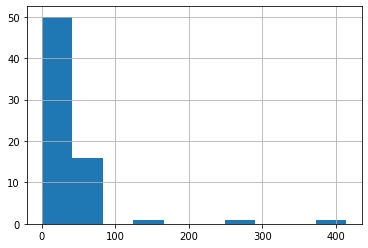

In [40]:
coords_in_mask['Area'].hist()

In [41]:
coords_in_mask_cleaned = coords_in_mask[coords_in_mask['Area']<100]
print(coords_in_mask_cleaned.shape)

(66, 3)


<AxesSubplot:>

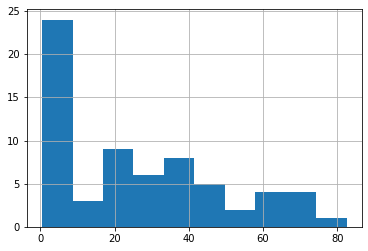

In [42]:
coords_in_mask_cleaned['Area'].hist()

In [44]:
thresholds3 = [1, 15, 15, 50, 50, 90]
particle_group_count = 3
results1, results2, results3 = sort_from_thresholds(coords_in_mask_cleaned, particle_group_count, thresholds3)
print(results1.shape)
print(results2.shape)
print(results3.shape)

(20, 2)
(28, 2)
(11, 2)
